<a href="https://colab.research.google.com/github/ashekhar20/league_predict/blob/master/simple_classifiers_v2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [0]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

In [0]:
base_url = 'https://raw.githubusercontent.com/ashekhar20/league_predict/master/data/'
data_dict=base_url+'data_dictionary.xlsx'
train_file=base_url+'train.csv'
test_file=base_url+'test.csv'

In [4]:
df1 = pd.read_csv(train_file)
df2 = pd.read_csv(test_file)
df1.shape, df2.shape

((252, 30), (76, 30))

Check for any column mismatch in train and test data

In [5]:
print("In Train, not in Test:")
for c in set(df1.columns):
  if c not in set(df2.columns):
    print(c)
  
print("In Test, not in Train:")
for c in set(df2.columns):
  if c not in set(df1.columns):
    print(c)

In Train, not in Test:
City
DayOfWeek
In Test, not in Train:
CityOfGame
Day


In [0]:
# rename two columns in test to match those in train
df2.rename(columns={"Day": "DayOfWeek", "CityOfGame":"City"}, inplace=True)

In [0]:
def preprocess_data(mydf):
  # Extract Year and Hour of the match
  mydf['DateTimeOfGame']=pd.to_datetime(mydf['DateOfGame']+'T'+mydf['TimeOfGame'])
  mydf['YearOfGame']=mydf['DateTimeOfGame'].dt.year
  mydf['HourOfGame']=mydf['DateTimeOfGame'].dt.hour
  
  # Is Home team batting first?
  mydf['isTeam1Home'] = mydf.apply(lambda x: x['City'] in x['Team 1'], axis=1)
  
  # Obtain match number for each team. 
  tmp1=mydf[['Team 1','YearOfGame','DateTimeOfGame']]
  tmp1.rename(columns={"Team 1": "Team"}, inplace=True)
  tmp2=mydf[['Team 2','YearOfGame','DateTimeOfGame']]
  tmp2.rename(columns={"Team 2": "Team"}, inplace=True)
  tmp=pd.concat([tmp1,tmp2])
  tt=tmp.groupby(['Team','YearOfGame'])["DateTimeOfGame"].rank("dense", ascending=True)
  tmp['TeamMatchNum']=tt.values.astype(int)
  tmp2=tmp.sort_values(by=['Team','DateTimeOfGame'])
  tmp2['match_key']=tmp2['Team']+tmp2['DateTimeOfGame'].astype(str)
  tmp2=tmp2.set_index('match_key')
  matchnum_dict=tmp2[['TeamMatchNum']].to_dict()
  # We'll update the main dataframe with TeamMatchNum using match_key (which is unique)
  # We'll create two new columns: Team1MatchNum and Team2MatchNum.
  mydf['match_key']=mydf['Team 1']+mydf['DateTimeOfGame'].astype(str)
  mydf['Team1MatchNum']=mydf['match_key'].map(matchnum_dict['TeamMatchNum'])
  mydf['match_key']=mydf['Team 2']+mydf['DateTimeOfGame'].astype(str)
  mydf['Team2MatchNum']=mydf['match_key'].map(matchnum_dict['TeamMatchNum'])
  
  return mydf
  
def prepare_data(mydf, feature_columns, dependant):
  tmpdf=mydf[feature_columns]
  tdf=pd.get_dummies(tmpdf)
  X=tdf.to_numpy()
  y=mydf[dependant].values
  
  return X,y, tdf.columns


In [8]:
traindf=preprocess_data(df1)
print(traindf.shape)

(252, 37)


/usr/local/lib/python3.6/dist-packages/pandas/core/frame.py:4025: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  return super(DataFrame, self).rename(**kwargs)


  Now our dataframe is ready for training. We'll identify the columns to be selected and take a subset of the dataframe. We'll return X matrix and y vector

In [0]:
feature_columns=['HourOfGame','isTeam1Home',
     'Team1MatchNum','Team2MatchNum','AvgWindSpeed', 'AvgHumidity',
     'Inn 1 Team 1 NOP R>25,SR>125', 'Inn 1 Team 1 NOP R<25, SR>125',
     'Inn 1 Team 1 Total 4s', 'Inn 1 Team 1 Total 6s',
     'Inn 1 Team 1 Max Strike Rate_ALLBatsmen',
     'Inn 1 Team 2 NoP fast bowlers', 'Inn 1 Team 2 NoP Spinners',
     'Inn 1 Team 2 wickets taken_catches_runout',
     'Inn1 Team 2 wickets taken_ bowled _lbw_caught by keeper_stumping',
     'Inn 1 Team 2 Extras conceded in_wides_No Balls',
     'Inn 2 Team 2 NOP R>25,SR>125', 'Inn 2 Team 2 NOP R<25, SR>125',
     'Inn 2 Team 2 Total 4s', 'Inn 2 Team 2 Total 6s',
     'Inn 2 Team 2 Max Strike Rate_ALLBatsmen',
     'Inn 2 Team 1 NoP fast bowlers', 'Inn 2 Team 1 NoP Spinners',
     'Inn 2 Team 1 wickets taken_catches_runout',
     'Inn2 Team 1 wickets taken_ bowled _lbw_caught by keeper_stumping',
     'Inn 2 Team 1 Extras conceded in_wides_No Balls',
     ]
dependant='Winner (team 1=1, team 2=0)'

In [10]:
trainX, trainY, trainCols = prepare_data(traindf, feature_columns, dependant)
print(trainX.shape, trainY.shape)

(252, 26) (252,)


In [11]:
testdf=preprocess_data(df2)
testX, y_true, testCols = prepare_data(testdf, feature_columns, dependant)
print(testX.shape, y_true.shape)

(76, 26) (76,)


/usr/local/lib/python3.6/dist-packages/pandas/core/frame.py:4025: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  return super(DataFrame, self).rename(**kwargs)


In [0]:
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC
from sklearn.metrics import confusion_matrix, accuracy_score, precision_score, recall_score, f1_score

In [0]:
lr = LogisticRegression(solver='lbfgs', max_iter=2000)
rfc = RandomForestClassifier(n_estimators=100)

        pred 0  pred 1
true 0      40       2
true 1       5      29


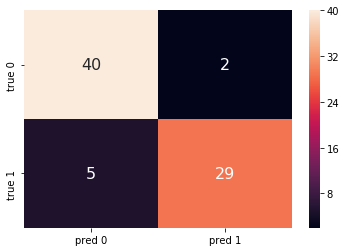

In [14]:
clf=lr
m=clf.fit(trainX, trainY)
y_pred=clf.predict(testX)
cm=confusion_matrix(y_true, y_pred)
cmdf=pd.DataFrame(cm,index=["true 0", "true 1"], columns=["pred 0", "pred 1"])
print(cmdf)
sns.heatmap(cmdf,annot=True,annot_kws={"size": 16})

In [16]:
clfnames=['Logistic Regression', 'Random Forest Classifier']
rep=[]
for clf, name in zip([lr, rfc], clfnames):
  m=clf.fit(trainX, trainY)
  y_pred=clf.predict(testX)
  accuracy=accuracy_score(y_true, y_pred)
  precision=precision_score(y_true, y_pred)
  recall=recall_score(y_true, y_pred)
  f1=f1_score(y_true, y_pred)
  rep.append([name,accuracy,precision,recall,f1])
  #print(name, accuracy)

resdf=pd.DataFrame(rep, columns=['classifier', 'accuracy', 'precision', 'recall', 'f1_score']).set_index('classifier')
resdf.head()

,accuracy,precision,recall,f1_score
classifier,,,,
Logistic Regression,0.907895,0.935484,0.852941,0.892308
Random Forest Classifier,0.881579,0.878788,0.852941,0.865672


Feature Importance from Random Forest Classifier

In [25]:
clf=rfc
m=clf.fit(trainX, trainY)
ft_imp=m.feature_importances_
ftdf=pd.DataFrame([trainCols,ft_imp]).T
ftdf.columns=['features','importance']
ftdf=ftdf.sort_values(by='importance',ascending=False)
sorted_features=ftdf['features'].values
sorted_features

array(['Inn 2 Team 1 wickets taken_catches_runout',
       'Inn2 Team 1 wickets taken_ bowled _lbw_caught by keeper_stumping',
       'Inn 1 Team 1 Total 6s', 'Inn 1 Team 1 Total 4s',
       'Inn 2 Team 2 Total 4s', 'Inn 2 Team 2 Max Strike Rate_ALLBatsmen',
       'Inn 1 Team 1 Max Strike Rate_ALLBatsmen',
       'Inn 1 Team 1 NOP R>25,SR>125', 'Inn 2 Team 2 Total 6s',
       'Inn 2 Team 1 Extras conceded in_wides_No Balls',
       'Inn1 Team 2 wickets taken_ bowled _lbw_caught by keeper_stumping',
       'AvgHumidity', 'Inn 2 Team 2 NOP R<25, SR>125',
       'Inn 1 Team 1 NOP R<25, SR>125',
       'Inn 1 Team 2 wickets taken_catches_runout', 'Team1MatchNum',
       'Team2MatchNum', 'Inn 2 Team 2 NOP R>25,SR>125',
       'Inn 1 Team 2 Extras conceded in_wides_No Balls', 'AvgWindSpeed',
       'HourOfGame', 'Inn 1 Team 2 NoP Spinners',
       'Inn 2 Team 1 NoP Spinners', 'Inn 1 Team 2 NoP fast bowlers',
       'Inn 2 Team 1 NoP fast bowlers'], dtype=object)

Let's take selected chunks of sorted features and check the logistic regression model

                 classifier  subset  accuracy  precision    recall  f1_score
0       Logistic Regression       5  0.881579   0.903226  0.823529  0.861538
1       Logistic Regression      10  0.921053   0.966667  0.852941  0.906250
2       Logistic Regression      15  0.947368   0.968750  0.911765  0.939394
3       Logistic Regression      20  0.907895   0.935484  0.852941  0.892308
4       Logistic Regression      25  0.907895   0.935484  0.852941  0.892308
5  Random Forest Classifier       5  0.894737   0.906250  0.852941  0.878788
6  Random Forest Classifier      10  0.921053   0.911765  0.911765  0.911765
7  Random Forest Classifier      15  0.907895   0.909091  0.882353  0.895522
8  Random Forest Classifier      20  0.921053   0.937500  0.882353  0.909091
9  Random Forest Classifier      25  0.894737   0.906250  0.852941  0.878788


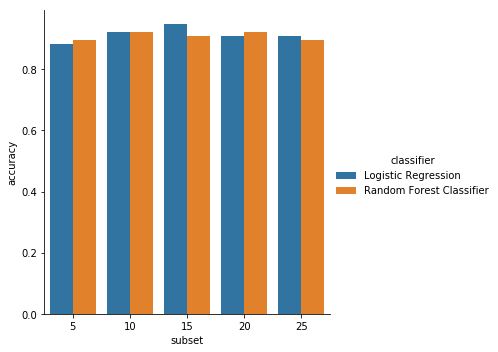

In [33]:
clfnames=['Logistic Regression', 'Random Forest Classifier']
rep=[]
for clf, name in zip([lr, rfc], clfnames):
  for i in [5, 10, 15, 20, 25]:
    sub_features=sorted_features[:i]
    trainX, trainY, trainCols = prepare_data(traindf, sub_features, dependant)
    testX, y_true, testCols = prepare_data(testdf, sub_features, dependant)
    m=clf.fit(trainX, trainY)
    y_pred=clf.predict(testX)
    accuracy=accuracy_score(y_true, y_pred)
    precision=precision_score(y_true, y_pred)
    recall=recall_score(y_true, y_pred)
    f1=f1_score(y_true, y_pred)
    rep.append([name,i,accuracy,precision,recall,f1])

resdf=pd.DataFrame(rep, columns=['classifier','subset', 'accuracy', 'precision', 'recall', 'f1_score'])
print(resdf.head(20))
g = sns.catplot(x="subset", y="accuracy", hue="classifier", data=resdf, kind="bar")

Logistic Regression with top 15 features performed the best (test accuracy = 94.7%)

accuracy= 0.9473684210526315 precision= 0.96875 recall= 0.9117647058823529 f1_score= 0.9393939393939394
        pred 0  pred 1
true 0      41       1
true 1       3      31


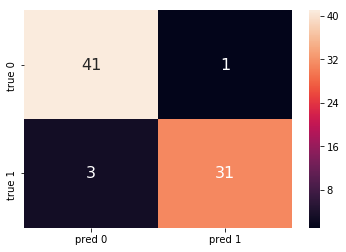

In [52]:
fm=LogisticRegression(solver='lbfgs', max_iter=2000)
sub_features=sorted_features[:15]
trainX, trainY, trainCols = prepare_data(traindf, sub_features, dependant)
testX, y_true, testCols = prepare_data(testdf, sub_features, dependant)
m=fm.fit(trainX, trainY)
y_pred=fm.predict(testX)
accuracy=accuracy_score(y_true, y_pred)
precision=precision_score(y_true, y_pred)
recall=recall_score(y_true, y_pred)
f1=f1_score(y_true, y_pred)
cm=confusion_matrix(y_true, y_pred)
cmdf=pd.DataFrame(cm,index=["true 0", "true 1"], columns=["pred 0", "pred 1"])
print("accuracy=", accuracy, "precision=", precision,"recall=",recall,"f1_score=", f1)
print(cmdf)
sns.heatmap(cmdf,annot=True,annot_kws={"size": 16})

Additional features that could be added:


1.   number of changes from last match (for each year). Team that change a lot may be less prone to winning
2.  Past League performance

